In [1]:
import torch
import numpy as np
import random
from IPython import display
from matplotlib import pyplot as plt
from torch import nn
import torch.utils.data as Data
import torch.optim as optim
from torch.nn import init
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"  #防止jupyter崩溃

In [4]:
#自定义数据---训练集
num_inputs = 200
#1类
x1 = torch.normal(2,1,(10000, num_inputs))
y1 = torch.ones(10000,1) # 标签1 
x1_train = x1[:7000]
x1_test = x1[7000:]
#0类
x2 = torch.normal(-2,1,(10000, num_inputs))
y2 = torch.zeros(10000,1) # 标签0
x2_train = x2[:7000]
x2_test = x2[7000:]
#合并训练集
# 注意 x, y 数据的数据形式一定要像下面一样 (torch.cat 是合并数据)---按行合并
trainfeatures = torch.cat((x1_train,x2_train), 0).type(torch.FloatTensor)
trainlabels = torch.cat((y1[:7000], y2[:7000]), 0).type(torch.FloatTensor)
#合并测试集
# 注意 x, y 数据的数据形式一定要像下面一样 (torch.cat 是合并数据)---按行合并
testfeatures = torch.cat((x1_test,x2_test), 0).type(torch.FloatTensor)
testlabels = torch.cat((y1[7000:], y2[7000:]), 0).type(torch.FloatTensor)
print(trainfeatures.shape,trainlabels.shape,testfeatures.shape,testlabels.shape)


torch.Size([14000, 200]) torch.Size([14000, 1]) torch.Size([6000, 200]) torch.Size([6000, 1])


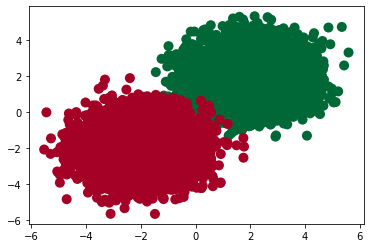

In [5]:
plt.scatter(trainfeatures.data.numpy()[:, 0], trainfeatures.data.numpy()[:, 1], c=trainlabels.data.numpy(), s=100, lw=0,
cmap='RdYlGn')

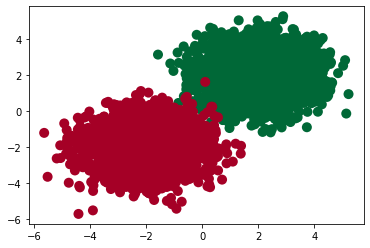

In [3]:
plt.scatter(testfeatures.data.numpy()[:, 0], testfeatures.data.numpy()[:, 1], c=testlabels.data.numpy(), s=100, lw=0,
cmap='RdYlGn')

In [4]:
#读取数据
batch_size = 50
# 将训练数据的特征和标签组合
dataset = Data.TensorDataset(trainfeatures, trainlabels)
# 把 dataset 放入 DataLoader
train_iter = Data.DataLoader(
    dataset=dataset, # torch TensorDataset format
    batch_size=batch_size, # mini batch size
    shuffle=True, # 是否打乱数据 (训练集一般需要进行打乱)
    num_workers=0, # 多线程来读数据， 注意在Windows下需要设置为0
)
# 将测试数据的特征和标签组合
dataset = Data.TensorDataset(testfeatures, testlabels)
# 把 dataset 放入 DataLoader
test_iter = Data.DataLoader(
    dataset=dataset, # torch TensorDataset format
    batch_size=batch_size, # mini batch size
    shuffle=True, # 是否打乱数据 (训练集一般需要进行打乱)
    num_workers=0, # 多线程来读数据， 注意在Windows下需要设置为0
)

In [5]:
#实现FlattenLayer层
class FlattenLayer(torch.nn.Module):
    def __init__(self):
         super(FlattenLayer, self).__init__()
    def forward(self, x):
        return x.view(x.shape[0],-1)

In [6]:
#模型定义和参数初始化
num_hiddens,num_outputs = 256,1
net = nn.Sequential(
        FlattenLayer(),
        nn.Linear(num_inputs,num_hiddens),
        nn.ReLU(),
        nn.Linear(num_hiddens,num_outputs)
        )

for params in net.parameters():
    init.normal_(params,mean=0,std=0.01)

In [7]:
lr = 0.0005
#定义交叉熵损失函数
loss = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(net.parameters(),lr)

In [8]:
#定义模型训练函数
def train(net,train_iter,test_iter,loss,num_epochs,batch_size,params=None,lr=None,optimizer=None):
    train_ls = []
    test_ls = []
    for epoch in range(num_epochs): # 训练模型一共需要num_epochs个迭代周期
        train_l_sum, train_acc_num,n = 0.0,0.0,0
        # 在每一个迭代周期中，会使用训练数据集中所有样本一次
        for X, y in train_iter: # x和y分别是小批量样本的特征和标签
            y_hat = net(X)
            l = loss(y_hat, y.view(-1,1)) # l是有关小批量X和y的损失
            #梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            l.backward() # 小批量的损失对模型参数求梯度
            if optimizer is None:
                SGD(params,lr)
            else:
                optimizer.step()
            #计算每个epoch的loss
            train_l_sum += l.item()*y.shape[0]
            #计算训练样本的准确率
            #train_acc_num += (y_hat[:0]==y).sum().item()
            #每一个epoch的所有样本数
            n+= y.shape[0]
        train_labels = trainlabels.view(-1,1)
        test_labels = testlabels.view(-1,1)
        train_ls.append(train_l_sum/n)
        test_ls.append(loss(net(testfeatures),test_labels).item())
        print('epoch %d, train_loss %.6f,test_loss %f'%(epoch+1, train_ls[epoch],test_ls[epoch]))
    return train_ls,test_ls

In [9]:
#训练次数和学习率
num_epochs = 50
train_loss,test_loss = train(net,train_iter,test_iter,loss,num_epochs,batch_size,net.parameters,lr,optimizer)

epoch 1, train_loss 0.533358,test_loss 0.370408
epoch 2, train_loss 0.238371,test_loss 0.140167
epoch 3, train_loss 0.095221,test_loss 0.064039
epoch 4, train_loss 0.048688,test_loss 0.037017
epoch 5, train_loss 0.030271,test_loss 0.024731
epoch 6, train_loss 0.021163,test_loss 0.018066
epoch 7, train_loss 0.015929,test_loss 0.013996
epoch 8, train_loss 0.012603,test_loss 0.011299
epoch 9, train_loss 0.010332,test_loss 0.009401
epoch 10, train_loss 0.008699,test_loss 0.008004
epoch 11, train_loss 0.007475,test_loss 0.006939
epoch 12, train_loss 0.006528,test_loss 0.006104
epoch 13, train_loss 0.005778,test_loss 0.005434
epoch 14, train_loss 0.005170,test_loss 0.004885
epoch 15, train_loss 0.004668,test_loss 0.004430
epoch 16, train_loss 0.004248,test_loss 0.004045
epoch 17, train_loss 0.003892,test_loss 0.003718
epoch 18, train_loss 0.003587,test_loss 0.003435
epoch 19, train_loss 0.003323,test_loss 0.003190
epoch 20, train_loss 0.003092,test_loss 0.002974
epoch 21, train_loss 0.002889

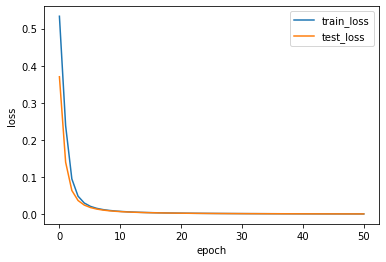

In [10]:
x = np.linspace(0,len(train_loss),len(train_loss))
plt.plot(x,train_loss,label="train_loss",linewidth=1.5)
plt.plot(x,test_loss,label="test_loss",linewidth=1.5)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()